# Transformer Training

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from transformer_model import *
import nltk
import sys
import matplotlib.pyplot as plt
sys.path.append("../../..")

from statapp.common.preprocessing import load_all_data, encode_data, split_into_X_y

from statapp.common.sampling import sample_token_sequence

## Preprocessing

Preprocessing maison assez brouillon pour le moment... L'encodage est effectué au niveau des mots. Les données exploitées sont placées dans le dossier data dans le dossier du notebook.

In [108]:
vocab_size = 1000

In [3]:
text = load_all_data("data/fr.train.top1M.txt", sample=0.00001)

tokens = nltk.word_tokenize(text)

vocab = list(set(tokens))

In [4]:
dico = {}

for word in vocab:
    dico[word]=0
    
for token in tokens:
    dico[token]+=1
    
sorted_list = sorted(dico.items(), key=lambda x: x[1], reverse=True)

sorted_dico = {}

for i in range(min(len(sorted_list),vocab_size-1)):
    sorted_dico[sorted_list[i][0]] = sorted_list[i][1]

In [5]:
for i in range(len(tokens)):
    if tokens[i] not in sorted_dico:
        tokens[i] = "<unk>"

In [6]:
vocab = list(set(tokens))

#if "<unk>" not in vocab:
#    vocab.append("<unk>")
    
vocab_size = len(vocab)

vocab_numbers = dict(zip(vocab, range(0,len(vocab))))
vocab_numeroted = dict(zip(range(0,len(vocab)), vocab))
tokens_numbers = np.array([vocab_numbers[tokens[i]] for i in range(len(tokens))])

tokens_numbers_sequences = np.array([ tokens_numbers[i:i+max_length+1] for i in range(len(tokens_numbers)-max_length)])
tokens_numbers_sequences = torch.tensor(tokens_numbers_sequences , dtype=torch.int64)

nb_sequences =  tokens_numbers_sequences.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size))

Les données exploitées contiennent 553 tokens (mots) au total.
La taille du vocabulaire ainsi constitué est de 269


In [8]:
"""text_test = load_all_data("data/fr.train.top1M.txt", sample=0.05, part="end")

tokens_test = nltk.word_tokenize(text_test)

vocab_test = list(set(tokens_test))

vocab_size_test = len(vocab_test)

vocab_numbers_test = dict(zip(vocab_test, range(0,len(vocab_test))))
vocab_numeroted_test = dict(zip(range(0,len(vocab_test)), vocab_test))
tokens_numbers_test = np.array([vocab_numbers_test[tokens_test[i]] for i in range(len(tokens_test))])

tokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])
tokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)

nb_sequences_test =  tokens_numbers_sequences_test.shape[0]

print("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))
print("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size_test))"""

'text_test = load_all_data("data/fr.train.top1M.txt", sample=0.05, part="end")\n\ntokens_test = nltk.word_tokenize(text_test)\n\nvocab_test = list(set(tokens_test))\n\nvocab_size_test = len(vocab_test)\n\nvocab_numbers_test = dict(zip(vocab_test, range(0,len(vocab_test))))\nvocab_numeroted_test = dict(zip(range(0,len(vocab_test)), vocab_test))\ntokens_numbers_test = np.array([vocab_numbers_test[tokens_test[i]] for i in range(len(tokens_test))])\n\ntokens_numbers_sequences_test = np.array([ tokens_numbers_test[i:i+max_length+1] for i in range(len(tokens_numbers_test)-max_length)])\ntokens_numbers_sequences_test = torch.tensor(tokens_numbers_sequences_test , dtype=torch.int64)\n\nnb_sequences_test =  tokens_numbers_sequences_test.shape[0]\n\nprint("Les données exploitées contiennent {} tokens (mots) au total.".format(len(tokens_test)))\nprint("La taille du vocabulaire ainsi constitué est de {}".format(vocab_size_test))'

## Apprentissage du modèle

In [113]:
LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
#Correspond à utiliser l'entropie croisée puisque les sorties sont des log_softmax
#et l'entropie croisée = nll_loss(log_softmax(.), target)
criterion = nn.NLLLoss()
optimizer = optim.Adam(LMtransformer.parameters(), lr=0.01)

In [114]:
def train_model(nb_epochs, batch_size):
    
    #What is this ?? I don't remember. Make grad required ?
    LMtransformer.train()
    
    #pas pour l'affichage progressif de la loss
    step = max(1,((len(tokens)-max_length-1)/batch_size)//5)
    
    epochs_losses = []
    losses = []
    
    for epoch in range(nb_epochs):
        
        running_loss = 0
        
        randperm = torch.randperm(nb_sequences)
        randperm = randperm[:(nb_sequences//batch_size)*batch_size]
        batchs_indices = randperm.reshape(nb_sequences//batch_size, batch_size)
        
        
        # running_loss_test = 0
        
        # randperm_test = torch.randperm(nb_sequences_test)
        #randperm_test = randperm_test[:(nb_sequences//batch_size)*batch_size]
        #batchs_indices_test = randperm_test.reshape(nb_sequences_test//batch_size, batch_size)
        
        
        for i, batch_indices in enumerate(batchs_indices):
            
            batch = tokens_numbers_sequences[batch_indices]
            optimizer.zero_grad()
            output = LMtransformer(batch[:,:-1])
            loss = criterion(output.reshape(-1, vocab_size), batch[:,1:].flatten())

            loss.backward()
            optimizer.step()
            
            #Il faudrait adapter les affichages en fonction du nombre de batchs total
            running_loss += loss.item()
            if i % step == step-1:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / step))
                
                #stock pour affichage graphique
                epochs_losses.append(epoch-1+(i/((len(tokens)-max_length-1)/batch_size)))
                losses.append(running_loss / step)
                
                running_loss = 0.
                
        plt.plot(epochs_losses, losses)

Test d'overfitting sur un cas ultrasimplifié (5 tokens, longueur de séquence 1, 3 decoders, 2 heads) :
- En observant les sorties le modèle a bien appris et overfitte ! (loss à 0 au bout de 5-6 epochs) 

[1,    10] loss: 4.602
[1,    20] loss: 3.389
[1,    30] loss: 2.687
[1,    40] loss: 1.913
[1,    50] loss: 1.713
[2,    10] loss: 1.157
[2,    20] loss: 1.103
[2,    30] loss: 1.045
[2,    40] loss: 0.928
[2,    50] loss: 0.920
[3,    10] loss: 0.783
[3,    20] loss: 0.762
[3,    30] loss: 0.775
[3,    40] loss: 0.661
[3,    50] loss: 0.760
[4,    10] loss: 0.622
[4,    20] loss: 0.575
[4,    30] loss: 0.648
[4,    40] loss: 0.609
[4,    50] loss: 0.573
[5,    10] loss: 0.550
[5,    20] loss: 0.507
[5,    30] loss: 0.597
[5,    40] loss: 0.616
[5,    50] loss: 0.615


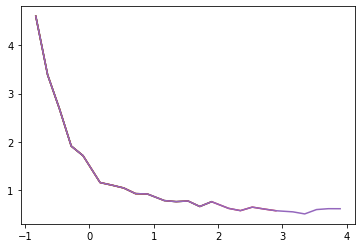

In [115]:
train_model(5,10)

## Sauvegarde des paramètres du modèle obtenu

In [117]:
torch.save({
    "nb_decoders" : nb_decoders,
    "vector_size" : vector_size,
    "nb_heads" : nb_heads,
    "head_size" : head_size,
    "max_length" : max_length,
    "ffn_hidden_size" : ffn_hidden_size,
    "vocab_size" : vocab_size,
    "model_params_dict" : LMtransformer.state_dict()}
    ,
    "params/LMtfparams"+str(np.random.rand())[2:])

In [2]:
#Later to restore:
lp = torch.load("params/LMtfparams7455419561970809")
print(lp)
nb_decoders = lp["nb_decoders"]
vector_size = lp["vector_size"]
nb_heads = lp["nb_heads"]
head_size = lp["head_size"]
max_length = lp["max_length"]
ffn_hidden_size = lp["ffn_hidden_size"]
vocab_size = lp["vocab_size"]
model_params_dict = lp["model_params_dict"]

LMtransformer = buildTransformer(vector_size, nb_decoders, nb_heads, head_size, ffn_hidden_size, vocab_size)
LMtransformer.load_state_dict(model_params_dict)

#Attention, pour pouvoir générer il faut reconstruire le vocabulaire et ses numéros associés avec le code plus haut

{'nb_decoders': 2, 'vector_size': 64, 'nb_heads': 4, 'head_size': 16, 'max_length': 8, 'ffn_hidden_size': 256, 'vocab_size': 269, 'model_params_dict': OrderedDict([('decoders.0.multihead_attention.w_q.weight', tensor([[-0.0252, -0.4441, -0.1588,  ..., -0.0376, -0.2381,  0.1855],
        [-0.2052, -0.3539,  0.1468,  ..., -0.3383,  0.1778,  0.0463],
        [-0.1713, -0.0288, -0.0151,  ..., -0.0672, -0.1919,  0.0813],
        ...,
        [-0.0639,  0.2691,  0.2535,  ..., -0.1409, -0.0648,  0.1145],
        [ 0.1918,  0.4472,  0.1806,  ..., -0.0150,  0.1312,  0.2238],
        [-0.0716,  0.2197, -0.1720,  ..., -0.0398, -0.1060, -0.1057]])), ('decoders.0.multihead_attention.w_q.bias', tensor([ 0.4162,  0.1516, -0.0395, -0.1261,  0.0252,  0.2988,  0.2507,  0.0060,
        -0.0243, -0.0673, -0.0181,  0.0653, -0.0703,  0.0041, -0.2356, -0.2741,
         0.2428, -0.0064, -0.0293,  0.2388,  0.0524,  0.0410, -0.1274, -0.2394,
        -0.1074,  0.1023,  0.0365, -0.2920, -0.0632, -0.1428,  0.1021,

        -1.7814e-01, -1.0464e-01,  5.5313e-02, -4.9438e-02]))])}


<All keys matched successfully>

## Génération

In [7]:
#bidouilles pour adapter nos fonctions aux fonctions common codées par Nathra 
#(sequence list of ints en entree, list of probas en sortie)
#(Faire mieux plus tard)
def LMtransformerprediction(listints):
    return np.exp(LMtransformer(torch.tensor([listints[-8:]]))[0][-1].tolist())

In [8]:
def gen_seq(prev_seq, top_k=5):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        sample_token_seq = sample_token_sequence(LMtransformerprediction, prev_seq_numbers, top_k=top_k)
        tokens_pred = [vocab_numeroted[i] for i in sample_token_seq]
        print(' '.join(tokens_pred)) 

In [9]:
"""def gen_seq_maison(prev_seq):
    with torch.no_grad():
        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]
        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))
        tokens_pred = vocab_numeroted[indice]
        print(' '.join(tokens_pred))"""

"def gen_seq_maison(prev_seq):\n    with torch.no_grad():\n        prev_seq_numbers = [vocab_numbers[token] for token in prev_seq]\n        indice = np.argmax(np.array(LMtransformer(torch.tensor([prev_seq_numbers]))))\n        tokens_pred = vocab_numeroted[indice]\n        print(' '.join(tokens_pred))"

In [10]:
gen_seq(['il'])

  0%|                                                  | 0/100 [00:00<?, ?it/s]C:\Users\Eric\statapp_language_model\statapp\transformer\pytorch\transformer_model.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(torch.add(embedded, pos_encodings), dtype=torch.float32)
100%|████████████████████████████████████████| 100/100 [00:01<00:00, 95.88it/s]


dur titres `` ans lumiere alain leurs 33 distributeur routes par ruthenie 39 prophetiques egalement societe alain pendant valeur le quand alain pendant cette via jacques vitoria-gasteiz weedub obtenu ainsi ( alain guerre qui 31 lorsque divine alain eau sont alain forale role eau cagnes alava fut aller contes la arrive favoriser dans eau noms aider lettres numerique partie alain fait centre 33 alain paru vitoria-gasteiz probablement 33 dure 33 barcelone avoir lorsque surface ducouret chanson <unk> commune vrai oth commune avoir lorsque ecraser ont 33 commune eau ma fut animait commune alain historien reprend connaissances commune reochestration son s


In [11]:
gen_seq(['a','l','age','de','31'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 87.39it/s]


lorsque goslicz commune perturbe industrie commune assume 33 egalement : commune d 31 lorsque goslicz commune perturbe industrie commune vrai oth commune commune avoir lorsque ecraser ont 33 commune eau ma fut animait commune alain historien reprend connaissances commune reochestration son s commune avoir lorsque territoires qui ' armee forcat messie avoir lorsque vive d titres 36 avoir lorsque touche qui villes aeroport met loc avoir lorsque surface ou commune ami connaissances 30 commune d 31 lorsque goslicz commune perturbe industrie commune assume 33 egalement : commune d 31 lorsque goslicz commune perturbe industrie commune assume 33 egalement : commune


In [12]:
gen_seq(['<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>','<unk>'], top_k=1)

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 98.82it/s]


33 enfants etat afin bureau siecle transmettre ' numerique leon histoire lorsque xxe prophetiques egalement societe alain pendant cette via jacques vitoria-gasteiz weedub obtenu ainsi ( alain guerre qui 31 lorsque divine alain eau sont alain forale role eau cagnes alava fut aller contes la arrive favoriser dans eau noms aider lettres numerique partie alain fait centre 33 alain paru vitoria-gasteiz probablement 33 dure 33 barcelone avoir lorsque surface ou commune lorsque surface ou commune 38 fernand la redige eau les commune avoir lorsque deputation 33 commune vrai oth commune avoir lorsque ecraser ont 33 commune eau ma fut animait


In [78]:
gen_seq(['barcelone',',','il','est','touche','par','l'])

100%|████████████████████████████████████████| 100/100 [00:01<00:00, 91.41it/s]


' esprit prophetique apres avoir obtenu la connaissance du vitoria-gasteiz de s ' ecraser valeur de tusson pendant la seconde moitie lumiere sur la surface du goudron qu ' il pourrait confondre avec la surface d ' une guerre entre la pologne et la ruthenie qui dure depuis plusieurs annees . ainsi , en 1281 , les polonais ont deja vaincu une armee mongole pres de goslicz , lorsque ces derniers sont entres sur les territoires de lech ii le noir pour aller aider leon ier de galicie galicie galicie . l ' histoire de la commune de tusson pendant


In [79]:
if len(tokens)<100:
    print(' '.join(tokens))